<a href="https://colab.research.google.com/github/Siarzis/ai-tutor/blob/main/cnn_mnist_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

Load MNIST dataset

In [19]:
# MNIST is a large database of handwritten digits
# commonly used for prototyping image processing systems

# MNIST includes 60,000 28x28 grayscale images of the 10 digits and a test set of 10,000 images

# define transforms to normalize the MNIST image data
transform = transforms.Compose([transforms.ToTensor(),  # Convert images to tensors, normalize to pixel values to the range [0, 1]
                                transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to the range [-1, 1]
                                ])

# define the batch size
bs = 64

# download and load the MNIST training dataset | "train_dataset" is an object of the dataset class
train_dataset = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transform)
# "train_loader" is an object of the DataLoader class
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True, pin_memory=True)

# download and load the MNIST test dataset
test_dataset = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, pin_memory=True)

Get MNIST image properties

In [3]:
print('Total number of MNIST images:', len(train_dataset))

# dataset class is subscriptable => train_dataset[0] is the first image of MNIST
# train_dataset[0] returns a tuble of the image (torch.Tensor) and its label (int)
image, label = train_dataset[0]
print('Image dimensions:', image.size(), 'Image label:', label)
print('Image channels:', image.size()[0])
print('Image size (height x width):', image.size()[1:])

print('Total number of batches:', len(train_dataset), '/', bs, '=', len(train_loader))

Total number of MNIST images: 60000
Image dimensions: torch.Size([1, 28, 28]) Image label: 5
Image channels: 1
Image size (height x width): torch.Size([28, 28])
Total number of batches: 60000 / 64 = 938


Visualize a sample image from MNIST

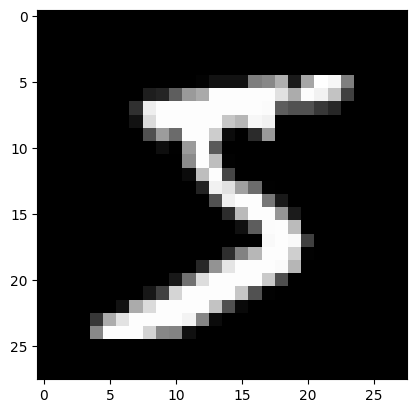

In [4]:
# convert MNIST sample image from PyTorch tensor to a NumPy array
image_np = image.numpy()

# visualize MNIST sample image using Matplotlib

# .squeeze() discards singleton dimensions - used to remove the channel dimension
plt.imshow(image_np.squeeze(), cmap='gray')
plt.show()

Further image visualization

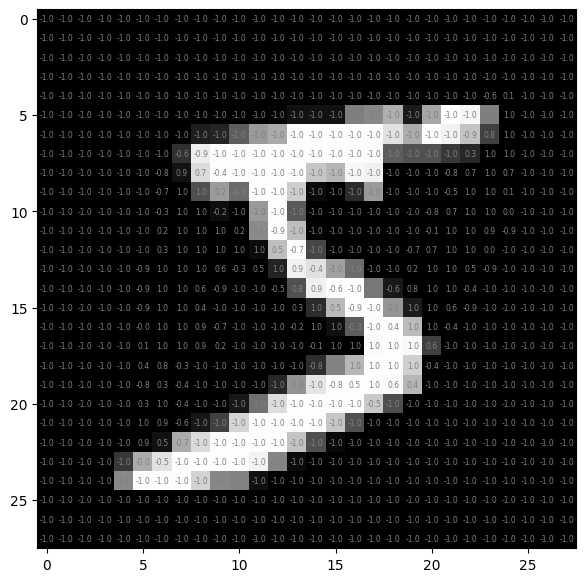

In [5]:
plt.figure(figsize=(7,7))
plt.imshow(image.squeeze(), cmap='gray')

for i in range(28):
    for j in range(28):
        pixel = round(image.squeeze()[i][j].item(), 1)
        plt.text(i, j, pixel, fontsize=5.5, ha='center', va='center', color='gray')

Define the MLP model

In [6]:
class ff_neural_network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ff_neural_network, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

# define feedforward neural network architecture
input_size = 784
hidden_size = 100
output_size = 10

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create an instance of the neural network
net = ff_neural_network(input_size, hidden_size, output_size)
net = nn.DataParallel(net)
net = net.to(device)

# define loss function and optimizer
criterion = nn.CrossEntropyLoss() # for classification tasks logarithmic/cross-entropy loss function is mainly used
optimizer = optim.SGD(net.parameters(), lr=0.01)

Train MLP model

In [7]:
epochs = 10

for e in range(epochs):

    # forward pass
    for i_batch, (image_batch, label_batch) in enumerate(train_loader):

        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        # MNIST images have to be flatten (28x28 array pixel -> 784 vector pixel)
        # MLP requires input images as vector of pixels (WHY?)
        flatten_image_batch = torch.squeeze(image_batch) # removes singleton (channel) dimension due to grayscale
        flatten_image_batch = torch.flatten(image_batch, start_dim=1)

        # flatten_image_batch = image_batch.reshape(image_batch.size(0), -1)

        if e == 0 and i_batch == 0:
            print(f'Batch: {i_batch}')
            print(f'Batch dimensions: {image_batch.shape}')
            print(f'Number of images per batch: {image_batch.shape[0]}')
            print(f'Flatten images shape: {flatten_image_batch.shape}')

        output = net(flatten_image_batch)

        # compute loss
        loss = criterion(output, label_batch)

        # backpropagation
        optimizer.zero_grad() # nullify gradients
        loss.backward() # propagate the loss backwards
        optimizer.step() # update weights

    print('Epoch [{}/{}], Loss: {:.4f}'.format(e+1, epochs, loss.item()))

Batch: 0
Batch dimensions: torch.Size([64, 1, 28, 28])
Number of images per batch: 64
Flatten images shape: torch.Size([64, 784])
Epoch [1/10], Loss: 0.3317
Epoch [2/10], Loss: 0.3125
Epoch [3/10], Loss: 0.2100
Epoch [4/10], Loss: 0.5715
Epoch [5/10], Loss: 0.5436
Epoch [6/10], Loss: 0.3293
Epoch [7/10], Loss: 0.2323
Epoch [8/10], Loss: 0.2221
Epoch [9/10], Loss: 0.3136
Epoch [10/10], Loss: 0.0642


Evaluate MLP model

In [20]:
correct = 0
total = 0

print(len(test_loader))
for i, (images_batch, labels_batch) in enumerate(test_loader):

    # termination condition to get the first 10 items of the "test_loader"
    if i == 10:
        break

    flatten_images_batch = torch.squeeze(image_batch)
    flatten_image_batch = torch.flatten(image_batch, start_dim=1)

    print(f'Batch: {i}')
    print(f'Batch dimensions: {image_batch.shape}')
    print(f'Label dimensions: {labels_batch.shape}')
    print(f'Number of images per batch: {image_batch.shape[0]}')
    print(f'Flatten images shape: {flatten_image_batch.shape}')

    output = net(flatten_image_batch)

    # predicted returns the indexes with the maximum probability (needs further explanation)
    _, predicted = torch.max(output.data, 1)

    print(labels_batch.shape[0])

    total += labels_batch.shape[0]
    # correct += (predicted == labels_batch).sum()

print('Accuracy of the MLP on the test MNIST dataset', 100*torch.true_divede(correct, total))

157
Batch: 0
Batch dimensions: torch.Size([32, 1, 28, 28])
Label dimensions: torch.Size([64])
Number of images per batch: 32
Flatten images shape: torch.Size([32, 784])
64
Batch: 1
Batch dimensions: torch.Size([32, 1, 28, 28])
Label dimensions: torch.Size([64])
Number of images per batch: 32
Flatten images shape: torch.Size([32, 784])
64
Batch: 2
Batch dimensions: torch.Size([32, 1, 28, 28])
Label dimensions: torch.Size([64])
Number of images per batch: 32
Flatten images shape: torch.Size([32, 784])
64
Batch: 3
Batch dimensions: torch.Size([32, 1, 28, 28])
Label dimensions: torch.Size([64])
Number of images per batch: 32
Flatten images shape: torch.Size([32, 784])
64
Batch: 4
Batch dimensions: torch.Size([32, 1, 28, 28])
Label dimensions: torch.Size([64])
Number of images per batch: 32
Flatten images shape: torch.Size([32, 784])
64
Batch: 5
Batch dimensions: torch.Size([32, 1, 28, 28])
Label dimensions: torch.Size([64])
Number of images per batch: 32
Flatten images shape: torch.Size([3

AttributeError: module 'torch' has no attribute 'true_divede'

possible fixes

1. add softmax after the output (linear) layer
2. check the "requires_grad()" of the training "image_batch"
3. obviously, try a new fnn architecture

